0. Installing dependecies

In [ ]:
!pip install stable-baselines[mpi]==2.8.0
#Download and install ROMs
!gdown -q http://www.atarimania.com/roms/Roms.rar
!pip install -q unrar
!mkdir ./roms_atari
!unrar x Roms.rar ./roms_atari > /dev/null 2>&1
!python -m atari_py.import_roms ./roms_atari > /dev/null 2>&1

     |████████████████████████████████| 222 kB 6.9 MB/s 
     |████████████████████████████████| 2.5 MB 53.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185352 sha256=1d8186c44b385a04d44427710dd70af52b4171176cf69e14b56e7e25734b21ee
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


0. Importing dependencies

In [ ]:
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from google.colab import drive
import gym.wrappers
# Creating a folder in Google Disk
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


1. Examine the Breakout environment

(210, 160, 3)


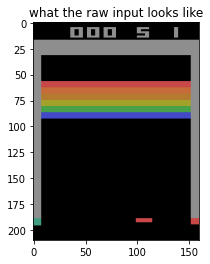

In [ ]:
# Observations (raw)
env = make_atari("BreakoutNoFrameskip-v4")
obs = np.array(env.reset())
print(obs.shape)
plt.title("what the raw input looks like")
plt.imshow(obs)

(84, 84, 4)


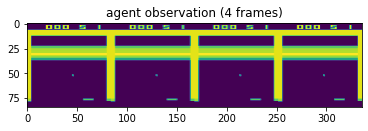

In [ ]:
# Obseravtions (wrapped)
env = make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
obs = np.array(env.reset())

#plt.title("what your network gonna see")
#plt.imshow(obs)

print(obs.shape)
plt.title("agent observation (4 frames)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))

In [ ]:
# Actions
print(env.action_space)
print(env.get_action_meanings())


Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


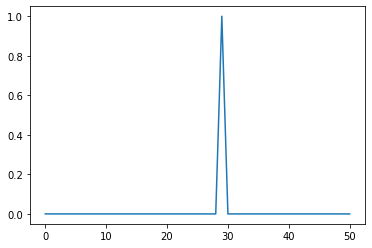

In [ ]:
# Rewards
env = make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.reset()
rewards = []
while True:
    obs, rew, done, info = env.step(env.action_space.sample())
    rewards.append(rew)
    if done:
        break
plt.plot(rewards)

2. Creating a model - Deep convolutional neural network

In [ ]:
num_actions = 4
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052  

3. Configuration paramaters for the whole setup

In [ ]:
seed = 42
gamma = 0.99  # Discount factor for past rewards

# Setting epsilon decay parameters
epsilon = 1.0  
epsilon_max_1 = 1.0 
epsilon_min_1 = 0.2  
epsilon_max_2 = epsilon_min_1  
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2  
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)  
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)  
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)  

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 190000

# Size of batch taken from replay buffer
batch_size = 32  
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 20

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()

4. Training the model

In [ ]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        if frame_count < epsilon_greedy_frames:
          epsilon -= epsilon_interval_1 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_1)
        
        if frame_count > epsilon_greedy_frames and frame_count < 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_2 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_2)
        
        if frame_count > 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_3 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_3)
          

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every 20th frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 18:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

running reward: 0.29 at episode 301, frame count 10000, epsilon 0.992, loss 0.01669
running reward: 0.22 at episode 606, frame count 20000, epsilon 0.984, loss 0.01292
running reward: 0.29 at episode 906, frame count 30000, epsilon 0.976, loss 0.01099
running reward: 0.33 at episode 1184, frame count 40000, epsilon 0.968, loss 0.01462
running reward: 0.32 at episode 1468, frame count 50000, epsilon 0.960, loss 0.00386
running reward: 0.34 at episode 1754, frame count 60000, epsilon 0.952, loss 0.01001
running reward: 0.19 at episode 2043, frame count 70000, epsilon 0.944, loss 0.00076
running reward: 0.23 at episode 2319, frame count 80000, epsilon 0.936, loss 0.00619
running reward: 0.37 at episode 2597, frame count 90000, epsilon 0.928, loss 0.00300
running reward: 0.25 at episode 2894, frame count 100000, epsilon 0.920, loss 0.00125
running reward: 0.32 at episode 3183, frame count 110000, epsilon 0.912, loss 0.00133
running reward: 0.35 at episode 3481, frame count 120000, epsilon 

5. Evaluating and saving the model

In [ ]:
# Creating a folder in Google Disk
#drive.mount('/content/gdrive', force_remount=True)

# Saving and loading the model
model_name = 'breakout_alpha_progress_21.44'
path = F"/content/gdrive/MyDrive/{model_name}" 
model = tf.keras.models.load_model(path)
#model.save(path)

6. Evaluating the model

In [ ]:
def make_env():
  env = make_atari("BreakoutNoFrameskip-v4")
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  return env

def evaluate(env, model, n_games=1, t_max=10000):
  
  rewards = []
  for _ in range(n_games):
    s = np.array(env.reset())
    reward = 0
    for _ in range(t_max):
      state_tensor = tf.convert_to_tensor(s)
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = model(state_tensor, training=False)
      action = tf.argmax(action_probs[0]).numpy()
      s, r, done, _ = env.step(action)
      s = np.array(s)
      reward += r
      if done:
        break
    
    rewards.append(reward)
    
  return np.mean(rewards)

In [ ]:
env = make_env()
evaluate(env, model, n_games=1)

98.0

6. Make videos of our agent play

In [ ]:
with gym.wrappers.Monitor(env, directory="videos_2", force=True) as env_monitor:
    sessions = [evaluate(env_monitor, model, n_games=1) for _ in range(100)]

In [ ]:
## What is "future rewards"

env = make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
state = np.array(env.reset())
state_tensor = tf.convert_to_tensor(state)
state_tensor = tf.expand_dims(state_tensor, 0)
action_probs = model(state_tensor, training=False)
action = tf.argmax(action_probs[0]).numpy()
s, r, done, _ = env.step(action)
s = np.array(s)

In [ ]:
state_tensor = tf.convert_to_tensor(s)
state_tensor = tf.expand_dims(state_tensor, 0)
future_rewards = model.predict(state_tensor)

In [ ]:
future_rewards

array([[3.147544 , 3.152832 , 3.0815547, 3.1499603]], dtype=float32)

Lost one life after 813 timesteps
{'ale.lives': 4}


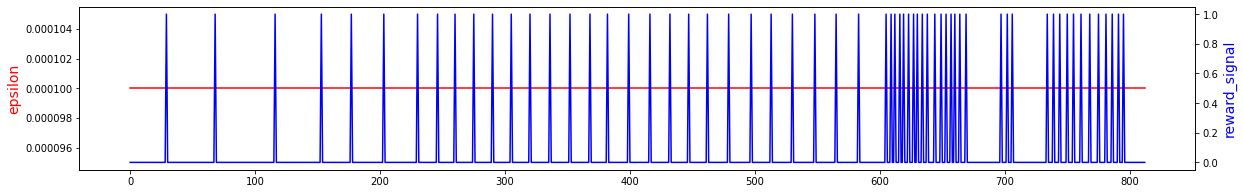

Bricks left to destroy  47.0
Lost one life after 1134 timesteps
{'ale.lives': 3}


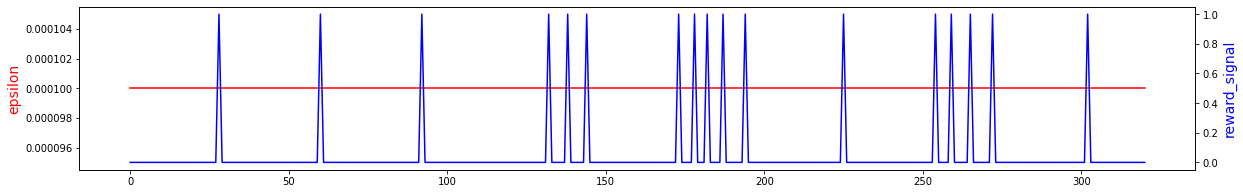

Bricks left to destroy  30.0
Lost one life after 1906 timesteps
{'ale.lives': 2}


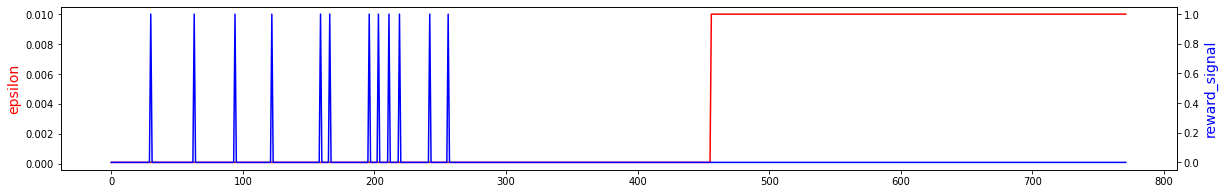

Bricks left to destroy  18.0
Lost one life after 2047 timesteps
{'ale.lives': 1}


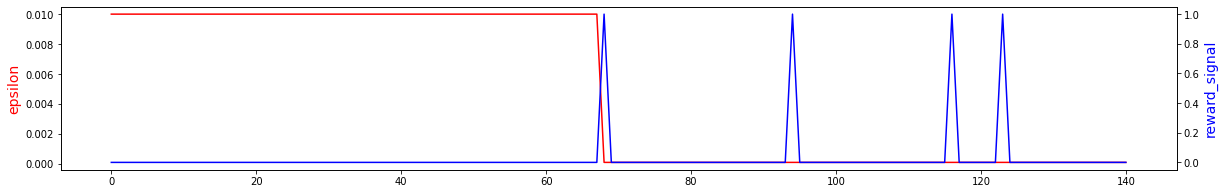

Bricks left to destroy  14.0
Lost one life after 2469 timesteps
{'ale.lives': 0}


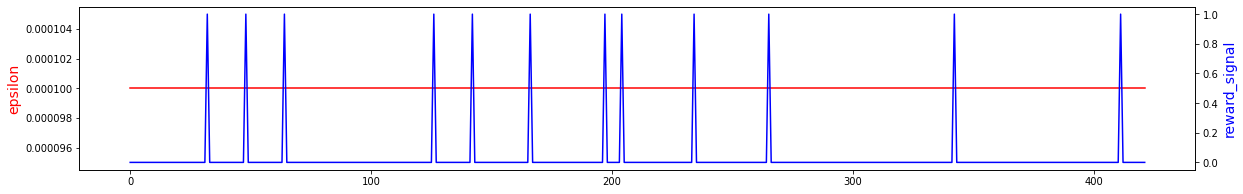

Bricks left to destroy  2.0


In [ ]:
env = make_env()
env = gym.wrappers.Monitor(env, "./vid1", force=True)

observation = env.reset()
info = 0
reward_window = []
reward_signal_history = []
epsilon_history = []

hits = []
bltd = 108 #total bricks to destroy

for i_episode in range(1):
    reward_window=[] 
    epsilon = 0  
    for t in range(4000):
        
        if epsilon > np.random.rand(1)[0]:
          action = np.random.choice(num_actions)
        else:
          state_tensor = tf.convert_to_tensor(observation)
          state_tensor = tf.expand_dims(state_tensor, 0)
          action_probs = model(state_tensor, training=False)
          action = tf.argmax(action_probs[0]).numpy()
        
        observation, reward, done, info = env.step(action)
        hits.append(reward)
        reward_window.append(reward)
        if len(reward_window) > 200:
          del reward_window[:1] 
        if len(reward_window) == 200 and np.sum(reward_window) == 0:
          epsilon = 0.01
        else:
          epsilon = 0.0001

        epsilon_history.append(epsilon)
        reward_signal_history.append(reward)

        
        if done:
            print("Lost one life after {} timesteps".format(t+1))
            print(info)
            # Plot epsilon and reward signal
            fig,ax=plt.subplots(figsize=(20,3))
            #plt.clf()
            ax.plot(epsilon_history, color="red")
            ax.set_ylabel("epsilon",color="red",fontsize=14)
            ax2=ax.twinx()
            ax2.plot(reward_signal_history,color="blue")
            ax2.set_ylabel("reward_signal",color="blue",fontsize=14)
            plt.show()

            epsilon_history = []
            reward_signal_history = []
            
            bltd = bltd-np.sum(hits)
            hits = []
            print("Bricks left to destroy ", bltd)
            if info['ale.lives'] == 0:
              break
            


            env.reset()
env.close()

running reward: 20.79 at episode 19, frame count 10000, epsilon 0.000


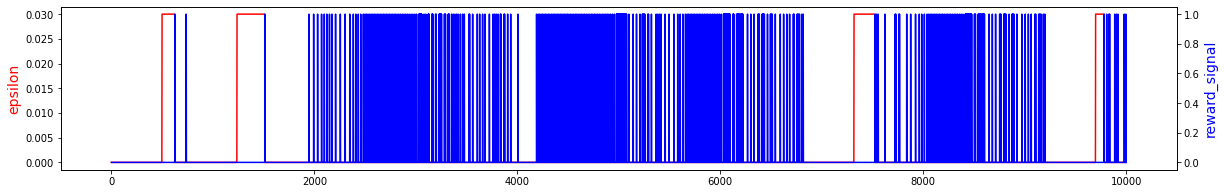

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_20.789473684210527/assets
running reward: 29.16 at episode 31, frame count 20000, epsilon 0.000


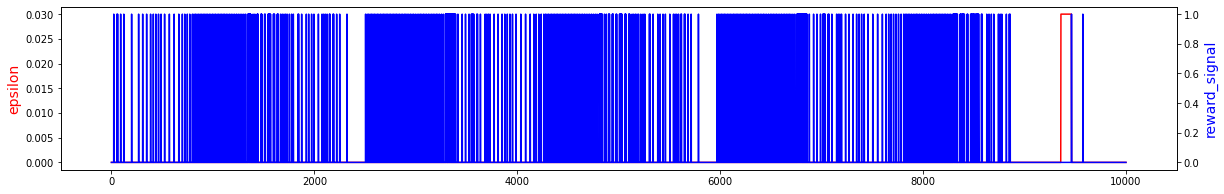

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_29.161290322580644/assets
running reward: 27.17 at episode 41, frame count 30000, epsilon 0.030


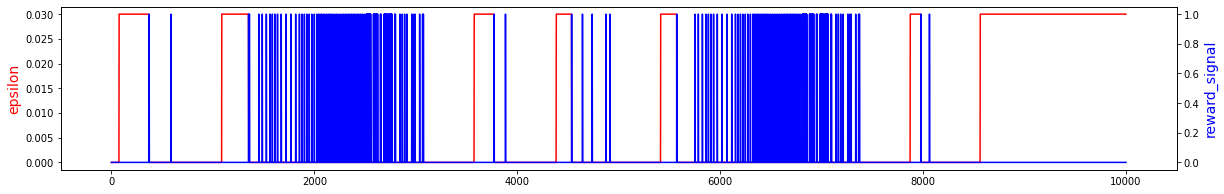

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_27.170731707317074/assets
running reward: 24.02 at episode 62, frame count 40000, epsilon 0.000


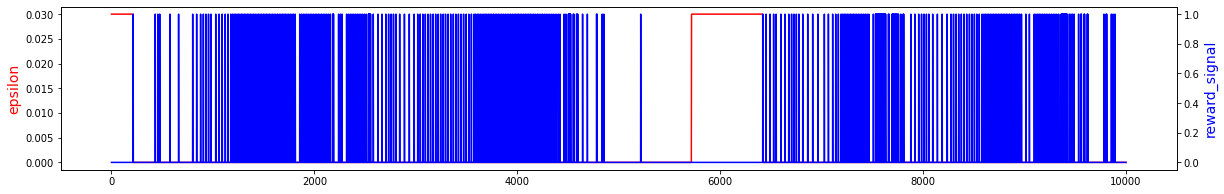

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_24.016129032258064/assets
running reward: 21.00 at episode 91, frame count 50000, epsilon 0.000


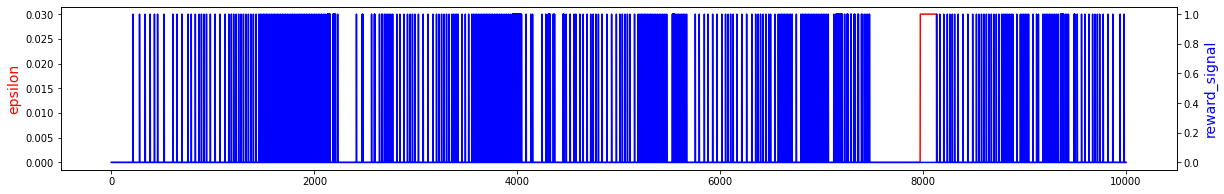

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_21.0/assets
running reward: 19.67 at episode 112, frame count 60000, epsilon 0.000


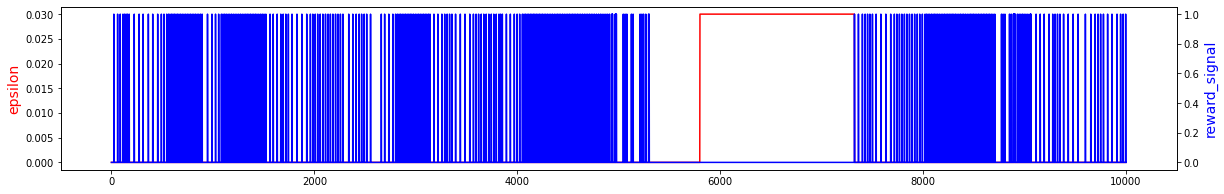

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_19.67/assets
running reward: 5.38 at episode 200, frame count 70000, epsilon 0.000


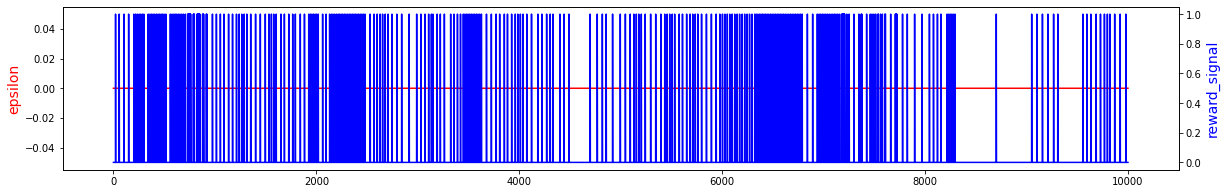

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_5.38/assets
running reward: 1.22 at episode 384, frame count 80000, epsilon 0.000


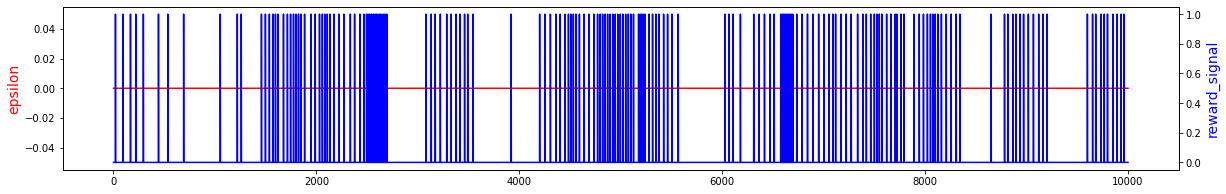

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_1.22/assets
running reward: 1.66 at episode 515, frame count 90000, epsilon 0.000


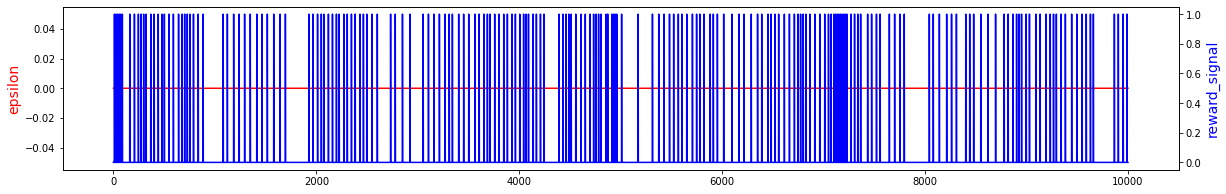

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_1.66/assets
running reward: 0.81 at episode 674, frame count 100000, epsilon 0.000


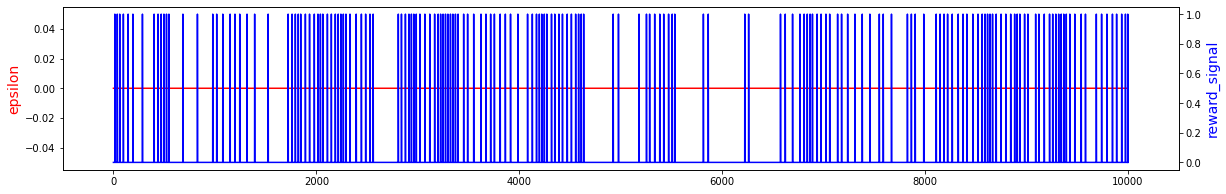

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_0.81/assets
running reward: 1.55 at episode 801, frame count 110000, epsilon 0.000


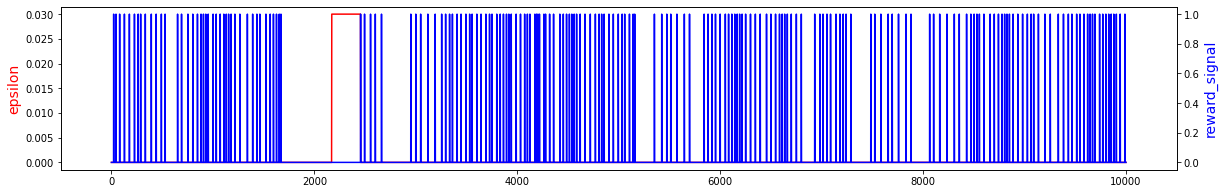

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_1.55/assets
running reward: 3.26 at episode 882, frame count 120000, epsilon 0.000


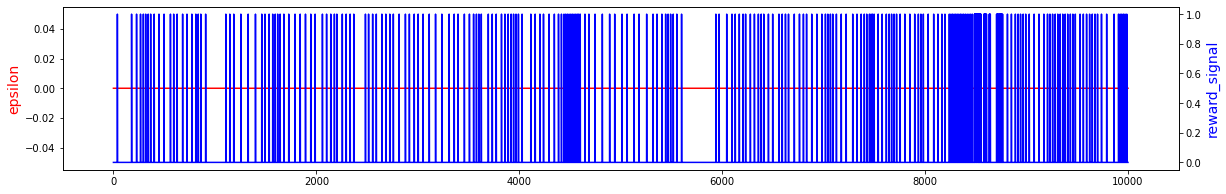

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_3.26/assets
running reward: 4.60 at episode 952, frame count 130000, epsilon 0.000


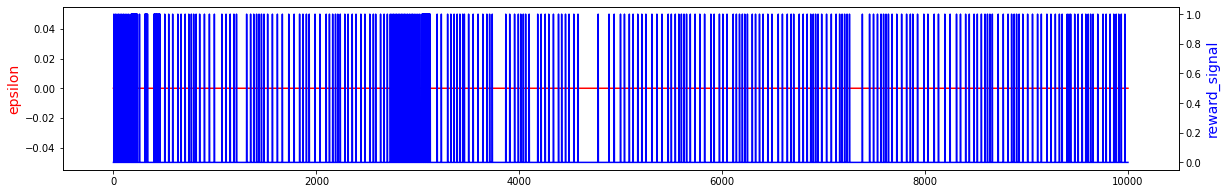

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_4.6/assets
running reward: 4.69 at episode 1003, frame count 140000, epsilon 0.000


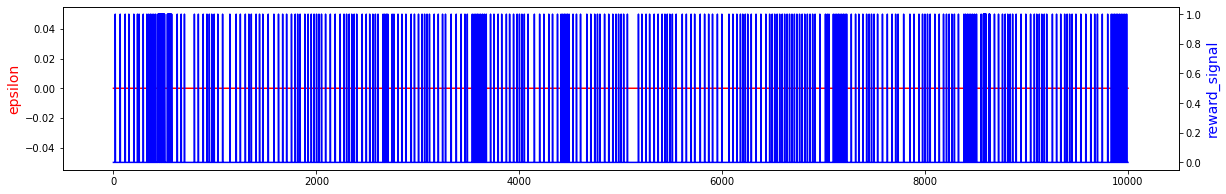

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_4.69/assets
running reward: 5.80 at episode 1060, frame count 150000, epsilon 0.000


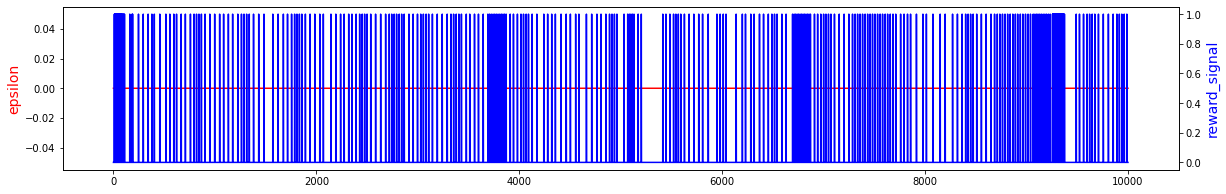

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_5.8/assets
running reward: 5.99 at episode 1115, frame count 160000, epsilon 0.000


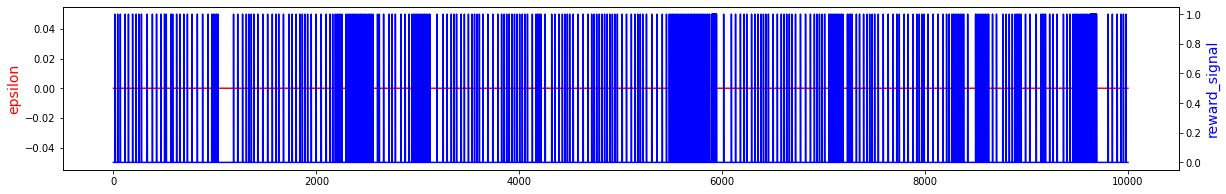

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_5.99/assets
running reward: 8.31 at episode 1156, frame count 170000, epsilon 0.000


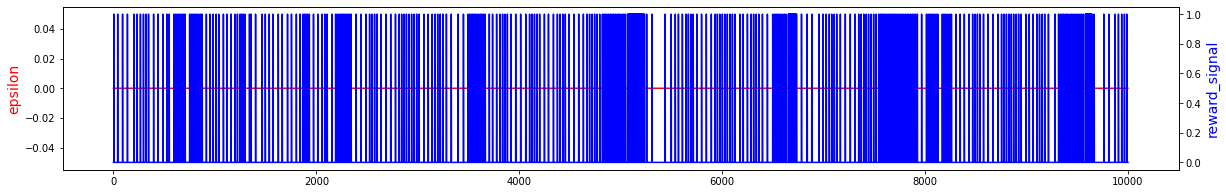

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_8.31/assets
running reward: 9.42 at episode 1190, frame count 180000, epsilon 0.000


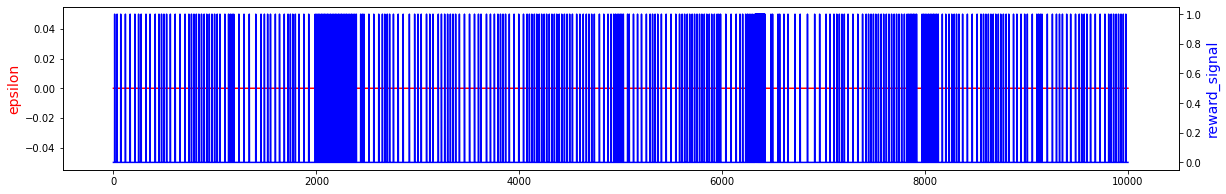

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_9.42/assets
running reward: 5.52 at episode 1272, frame count 190000, epsilon 0.000


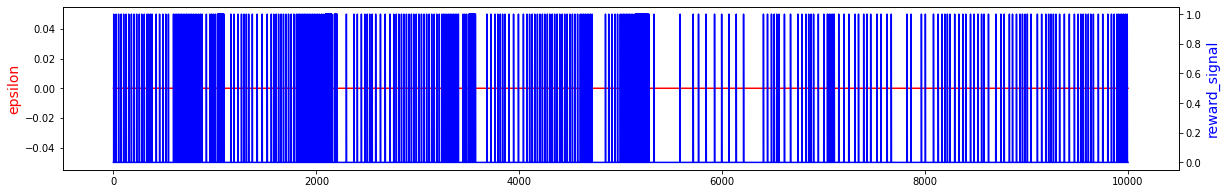

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_5.52/assets
running reward: 4.42 at episode 1317, frame count 200000, epsilon 0.000


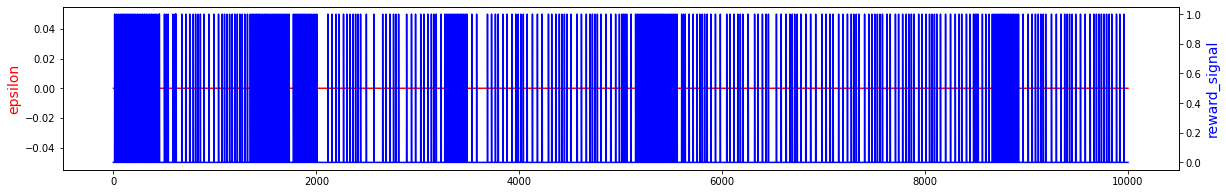

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_4.42/assets
running reward: 8.38 at episode 1358, frame count 210000, epsilon 0.000


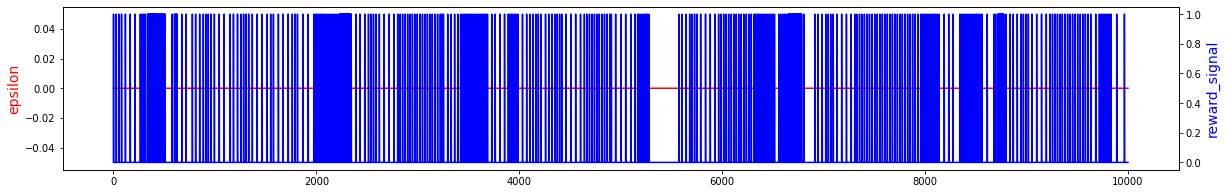

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_8.38/assets
running reward: 8.72 at episode 1403, frame count 220000, epsilon 0.000


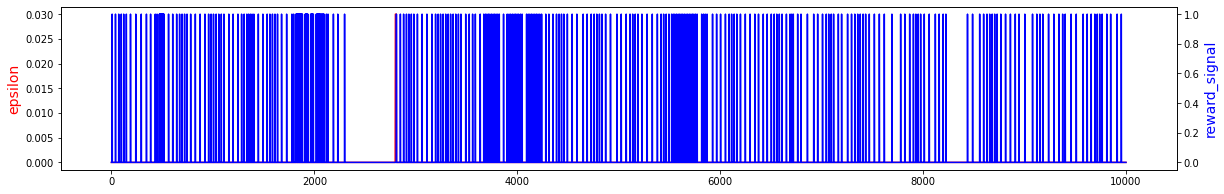

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_8.72/assets
running reward: 9.45 at episode 1436, frame count 230000, epsilon 0.000


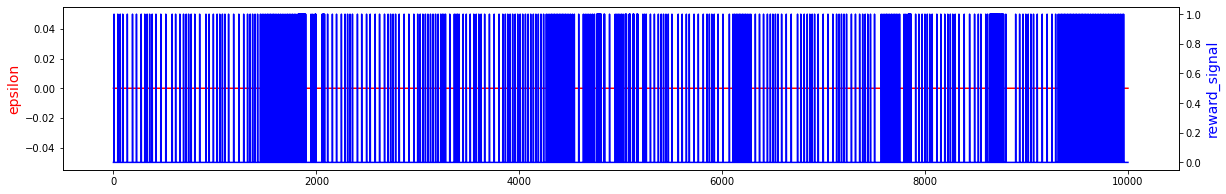

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_9.45/assets
running reward: 9.48 at episode 1467, frame count 240000, epsilon 0.000


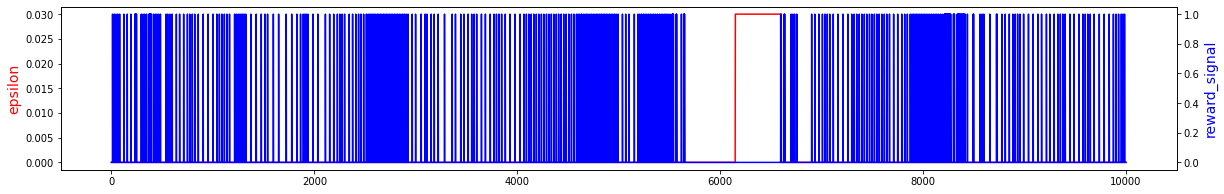

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_9.48/assets
running reward: 12.49 at episode 1501, frame count 250000, epsilon 0.000


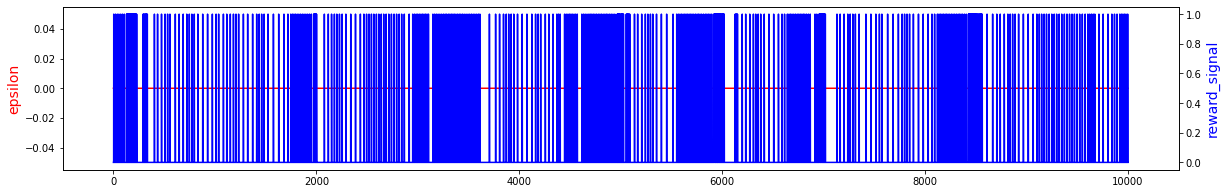

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_12.49/assets
running reward: 11.27 at episode 1550, frame count 260000, epsilon 0.000


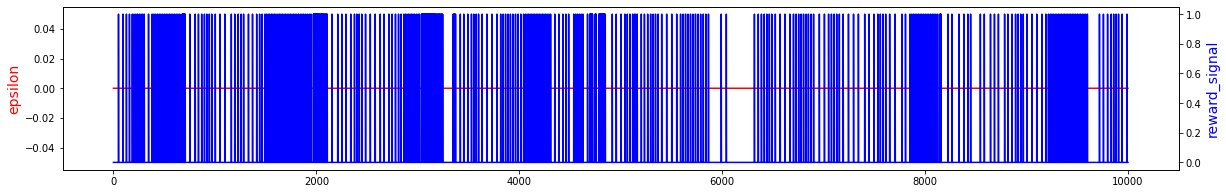

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_11.27/assets
running reward: 11.55 at episode 1580, frame count 270000, epsilon 0.000


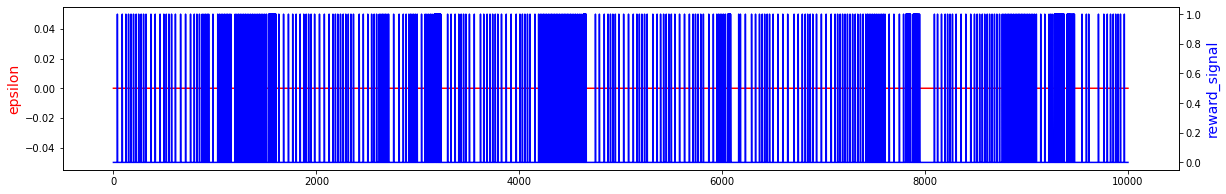

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_11.55/assets
running reward: 11.36 at episode 1610, frame count 280000, epsilon 0.000


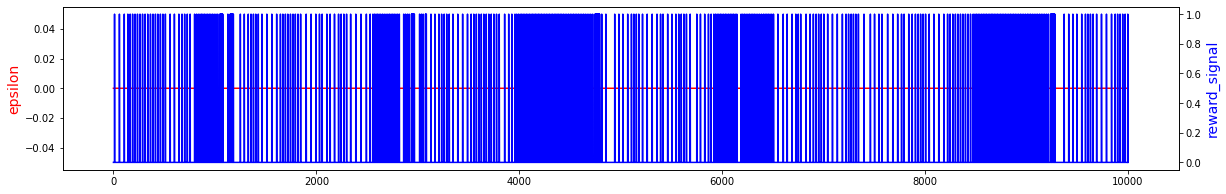

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/breakout_alpha_progress_11.36/assets


KeyboardInterrupt: ignored

In [ ]:
model = model
model_target = model
epsilon_greedy_frames = 5
epsilon_random_frames = 0
max_steps_per_episode = 10000
max_memory_length = 180000
batch_size = 32
update_after_actions = 10



# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
reward_window = []

reward_signal_history = []
epsilon_history = []

optimizer = keras.optimizers.Adam(learning_rate=0.00015, clipnorm=1.0)

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()
          

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward
        
        
        reward_window.append(reward)
        if len(reward_window) > 500:
          del reward_window[:1] 
        if len(reward_window) >= 499 and np.sum(reward_window) == 0:
          epsilon = 0.03
        else:
          epsilon = 0

          

    

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        
        epsilon_history.append(epsilon)
        reward_signal_history.append(reward)


        state = state_next

        # Update every 10th frame and once batch size is over 64
        if frame_count > 30000 and frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon))
            
            # Plot epsilon and reward signal
            fig,ax=plt.subplots(figsize=(20,3))
            #plt.clf()
            ax.plot(epsilon_history, color="red")
            ax.set_ylabel("epsilon",color="red",fontsize=14)
            ax2=ax.twinx()
            ax2.plot(reward_signal_history,color="blue")
            ax2.set_ylabel("reward_signal",color="blue",fontsize=14)
            plt.show()
            
            #Save model to GDrive
            model_name = 'breakout_alpha_progress_'
            model_name = str(model_name)+str(running_reward)
            path = F"/content/gdrive/MyDrive/{model_name}" 
            model.save(path)
            

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]
        if len(epsilon_history) > 10000:
            del epsilon_history[:1]
            del reward_signal_history[:1]


        if done:
            break
            

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break